# CanESM5 GMD paper Figure 27 
## SI trends

### history
-  SJH, first look 2019-04-30

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from matplotlib import cm
%matplotlib inline
from pprint import pprint
import os
from datetime import datetime
import calendar
import pandas as pd
import pickle
from scipy import stats
import modules.basic_stats as bst
import modules.plotting_module as pltm
from cdo import Cdo

cdo = Cdo()
cdo.setCdo('/home/ords/crd/ccrn/scrd104/miniconda3/bin/cdo')

/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [3]:
#variable defs
%store -r tr_start 
%store -r tr_end
%store -r color_dict
%store -r m2_per_km2

start = tr_start
end = tr_end
startdate = datetime.strptime(start,'%Y-%m-%d')
enddate   = datetime.strptime(end,'%Y-%m-%d')

nh_month = 9
sh_month = 'all'
siconc_limit = 15
x_vals = np.linspace(-16e4, 2e4, 1e4)

CanESM5_dir = 'input_data/CanESM5_cmip_dir/historical/'
CanESM2_dir = 'input_data/CanESM2_combined_ensemble/sic/'

/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  from ipykernel import kernelapp as app


In [4]:
#remapping to a common grid so we can calculate stats on the 2D time mean 

runCDO = False

if runCDO:
    CanESM5_siconc = 'siconc_SImon_CanESM5_historical_r1i1p1f1_gn_185001-201412.nc'
    ifile = os.path.join('input_data/CanESM5_cmip_dir/historical/r1i1p1f1/SImon/siconc/gn/v20190429/', CanESM5_siconc)
    ofile = 'input_data/processed_data/remap-woa09_' + CanESM5_siconc
    cdo.remapbil('input_data/obs/woa/woa09/uncs_woa09_ann_tpot.nc', input=ifile, output=ofile)
    
    CanESM2_siconc = 'sic_OImon_CanESM2_historical_d1r1i1p1_195001-202012.nc'
    ifile = os.path.join('input_data/CanESM2_combined_ensemble/sic/', CanESM2_siconc)
    ofile = 'input_data/processed_data/remap-woa09_' + CanESM2_siconc
    cdo.remapbil('input_data/obs/woa/woa09/uncs_woa09_ann_tpot.nc', input=ifile, output=ofile)
    
    NSIDC_siconc_nh = 'seaice_conc_monthly_nh_1978-2017_v03r01.nc'
    ifile = os.path.join('input_data/processed_data/', NSIDC_siconc_nh)
    ofile = 'input_data/processed_data/remap-woa09_' + NSIDC_siconc_nh
    cdo.remapbil('input_data/obs/woa/woa09/uncs_woa09_ann_tpot.nc', input=ifile, output=ofile)
    
    NSIDC_siconc_sh = 'seaice_conc_monthly_sh_1978-2017_v03r01.nc'
    ifile = os.path.join('input_data/processed_data/', NSIDC_siconc_sh)
    ofile = 'input_data/processed_data/remap-woa09_' + NSIDC_siconc_sh
    cdo.remapbil('input_data/obs/woa/woa09/uncs_woa09_ann_tpot.nc', input=ifile, output=ofile)
    
  

In [5]:
#get CanESM5 timeseries and trends for all realizations
#this takes a bit of time, so the output is pickled and this step can be skipped unless changes are needed

CanESM5 = {}
areacello_CanESM5 = xr.open_dataset('input_data/CanESM5_cmip_dir/historical/r1i1p1f1/Ofx/areacello/gn/v20190429/areacello_Ofx_CanESM5_historical_r1i1p1f1_gn.nc')

process_CanESM5_realizations = False
if process_CanESM5_realizations:
    i=0
    print('CanESM5')
    for root, subdirs, files in os.walk(CanESM5_dir):
        
        for filename in files:
            try:
                var, tab, model, expt, rl, grid, dates = filename.split('_')
            except:
                continue
           
            if tab == 'SImon' and var == 'siconc' and rl.endswith('i1p1f1'): 
                i+=1
                print(rl,os.path.join(root,filename), datetime.now(), i)
                
                #open file
                ds = xr.open_dataset(os.path.join(root,filename))['siconc']

                #merge with areacello
                merged = xr.merge([ds,areacello_CanESM5])
                merged['time']  = merged.indexes['time'].to_datetimeindex() #convert from cftime to datetimeindex

                #separate by hemisphere
                merged_nh = merged.where(merged.latitude > 0)
                merged_sh = merged.where(merged.latitude < 0)

                #select data by siconc limit (in %) *****
                merged_nh_si = merged_nh.where(merged_nh.siconc >= siconc_limit)
                merged_sh_si = merged_sh.where(merged_sh.siconc >= siconc_limit)

                #get si extent ts
                merged_nh_si_areasum = merged_nh_si.areacello.sum(dim=['i', 'j'])/m2_per_km2 #convert to km2
                merged_sh_si_areasum = merged_sh_si.areacello.sum(dim=['i', 'j'])/m2_per_km2 #convert to km2

                #get trends data for the selected period
                merged_nh_si_areasum_selyrs = merged_nh_si_areasum.sel(time=slice(start,end)) 
                #annual
                merged_nh_si_areasum_annmeans = pltm.get_month_weighted_annual_means(merged_nh_si_areasum_selyrs, 'noleap', start, end)
                cov_nh,cor_nh,slope_nh,intercept_nh,pval_nh,stderr_nh = (pltm.Linregress3D(merged_nh_si_areasum_annmeans.year, merged_nh_si_areasum_annmeans))
                #monthly
                monthly_nh_si = merged_nh_si_areasum_selyrs.groupby('time.month')
                monthly_trends_nh_si = monthly_nh_si.apply(pltm.Linregress3Dds)

                
                merged_sh_si_areasum_selyrs = merged_sh_si_areasum.sel(time=slice(start,end)) 
                #annual
                merged_sh_si_areasum_annmeans = pltm.get_month_weighted_annual_means(merged_sh_si_areasum_selyrs, 'noleap', start, end)
                cov_sh,cor_sh,slope_sh,intercept_sh,pval_sh,stderr_sh = (pltm.Linregress3D(merged_sh_si_areasum_annmeans.year, merged_sh_si_areasum_annmeans))
                #monthly
                monthly_sh_si = merged_sh_si_areasum_selyrs.groupby('time.month')
                monthly_trends_sh_si = monthly_sh_si.apply(pltm.Linregress3Dds) #in m2/year
                
                CanESM5[rl] = {
                    'siextent_ts_nh':merged_nh_si_areasum,
                    'siextent_ts_sh':merged_sh_si_areasum,
                    'annual_trends_nh':slope_nh,
                    'annual_trends_sh':slope_sh, 
                    'monthly_trends_nh':monthly_trends_nh_si,
                    'monthly_trends_sh':monthly_trends_sh_si}
            
            
    with open('input_data/processed_data/CanESM5_seaice.pickle', 'wb') as f:
        pickle.dump(CanESM5, f)
        
else:
    with open('input_data/processed_data/CanESM5_seaice.pickle', 'rb') as f:
        CanESM5 = pickle.load(f)



In [6]:
#get CanESM2 timeseries and trends for all realizations
#this takes a bit of time, so the output is pickled and this step can be skipped unless changes are needed

CanESM2 = {}

#areacella is slightly different in the large vs small ensembles
areacella_CanESM2_le = xr.open_dataset('input_data/CanESM2_large_ensemble/historical-r1/fx/atmos/areacella/r0i0p0/areacella_fx_CanESM2_historical-r1_r0i0p0.nc')
areacella_CanESM2_se = xr.open_dataset('input_data/CanESM2_small_ensemble/fx/atmos/areacella/r0i0p0/areacella_fx_CanESM2_historical_r0i0p0.nc')

process_CanESM2_realizations = False
if process_CanESM2_realizations:
    i=0
    print('CanESM2')
    for root, subdirs, files in os.walk(CanESM2_dir):
        for filename in files:
            if filename.startswith('sic_OImon_CanESM2_historical') and ('p1' in filename): 
                var, tab, model, expt, rl, dates = filename.split('_')
                i+=1
                print(rl, datetime.now(), i)
                
                #open file
                ds = xr.open_dataset(os.path.join(root,filename))['sic']

                #merge with areacella
                if filename.startswith('sic_OImon_CanESM2_historical_r'):
                    ds = ds.sel(time=slice('1800-01-01','1950-01-01')) #only use small ensemble data pre-1950 to avoid duplicate realizations (r1i1p1 == d1r1i1p1 extended backward)
                    merged = xr.merge([ds,areacella_CanESM2_se])
                else:
                    merged = xr.merge([ds,areacella_CanESM2_le])
                merged['time']  = merged.indexes['time'].to_datetimeindex()
                
                #separate by hemisphere
                merged_nh = merged.where(merged.lat > 0)
                merged_sh = merged.where(merged.lat < 0)
                
                #select data by siconc limit (in %)
                merged_nh_si = merged_nh.where(merged_nh.sic >= siconc_limit)
                merged_sh_si = merged_sh.where(merged_sh.sic >= siconc_limit)
                
                #get si extent timeseries
                merged_nh_si_areasum = merged_nh_si.areacella.sum(dim=['lat', 'lon'])/m2_per_km2 #convert to km2
                merged_sh_si_areasum = merged_sh_si.areacella.sum(dim=['lat', 'lon'])/m2_per_km2 #convert to km2
                
                CanESM2[rl] = {'siextent_ts_nh': merged_nh_si_areasum,
                               'siextent_ts_sh': merged_sh_si_areasum}
                
                #get trends data for the selected period
                #don't calc trends for small ensemble or there will be duplicates
                if filename.startswith('sic_OImon_CanESM2_historical_d'):
                    merged_nh_si_areasum_selyrs = merged_nh_si_areasum.sel(time=slice(start,end)) 
                    #annual
                    merged_nh_si_areasum_annmeans = pltm.get_month_weighted_annual_means(merged_nh_si_areasum_selyrs, 'noleap', start, end)
                    cov_nh,cor_nh,annual_trends_nh,intercept_nh,pval_nh,stderr_nh = (pltm.Linregress3D(merged_nh_si_areasum_annmeans.year, merged_nh_si_areasum_annmeans))
                    #monthly
                    monthly_nh_si = merged_nh_si_areasum_selyrs.groupby('time.month')
                    monthly_trends_nh = monthly_nh_si.apply(pltm.Linregress3Dds)

                    merged_sh_si_areasum_selyrs = merged_sh_si_areasum.sel(time=slice(start,end)) 
                    #annual
                    merged_sh_si_areasum_annmeans = pltm.get_month_weighted_annual_means(merged_sh_si_areasum_selyrs, 'noleap', start, end) 
                    cov_sh,cor_sh,annual_trends_sh,intercept_sh,pval_sh,stderr_sh = (pltm.Linregress3D(merged_sh_si_areasum_annmeans.year, merged_sh_si_areasum_annmeans))
                    #monthly
                    monthly_sh_si = merged_sh_si_areasum_selyrs.groupby('time.month')
                    monthly_trends_sh = monthly_sh_si.apply(pltm.Linregress3Dds) #in m2/year
                
                    CanESM2[rl]['annual_trends_nh'] = annual_trends_nh
                    CanESM2[rl]['annual_trends_sh'] = annual_trends_sh
                    CanESM2[rl]['monthly_trends_nh'] = monthly_trends_nh
                    CanESM2[rl]['monthly_trends_sh'] = monthly_trends_sh

                
    with open('input_data/processed_data/CanESM2_seaice.pickle', 'wb') as f:
        pickle.dump(CanESM2, f)        

else:
    with open('input_data/processed_data/CanESM2_seaice.pickle', 'rb') as f:
        CanESM2 = pickle.load(f)    

In [7]:
#NSIDC
pct = 100

#get the data files
siconc_NSIDC_nh   = xr.open_dataset('input_data/processed_data/seaice_conc_monthly_nh_1978-2017_v03r01.nc').sel(time=slice('1979-01-01','2018-01-01')) #remove 1978 because it only has data for last half of year 
siconc_NSIDC_sh   = xr.open_dataset('input_data/processed_data/seaice_conc_monthly_sh_1978-2017_v03r01.nc').sel(time=slice('1979-01-01','2018-01-01')) #remove 1978 because it only has data for last half of year 

#select data by siconc limit (in %)
siconc_NSIDC_nh_si = siconc_NSIDC_nh.where(siconc_NSIDC_nh.goddard_merged_seaice_conc_monthly >= siconc_limit/pct)
siconc_NSIDC_sh_si = siconc_NSIDC_sh.where(siconc_NSIDC_sh.goddard_merged_seaice_conc_monthly >= siconc_limit/pct)

#get si extent
grid_cell_area = 25*25 #data is on a 25x25km equal area grid
siextent_NSIDC_nh = siconc_NSIDC_nh_si.goddard_merged_seaice_conc_monthly.count(dim=['xgrid','ygrid'])*grid_cell_area #in km2
siextent_NSIDC_sh = siconc_NSIDC_sh_si.goddard_merged_seaice_conc_monthly.count(dim=['xgrid','ygrid'])*grid_cell_area 

#account for arctic pole hole (https://nsidc.org/data/g02202/versions/3#title16 - table 8)
siextent_NSIDC_nh = (siextent_NSIDC_nh+1.19e6).where(siextent_NSIDC_nh['time']< np.datetime64('1987-07-01'),siextent_NSIDC_nh)
siextent_NSIDC_nh = (siextent_NSIDC_nh+0.31e6).where(siextent_NSIDC_nh['time'] >= np.datetime64('1987-07-01'),siextent_NSIDC_nh)
siextent_NSIDC_nh = (siextent_NSIDC_nh-0.31e6+0.029e6).where(siextent_NSIDC_nh['time']>=np.datetime64('2007-12-31'),siextent_NSIDC_nh)

#get trends 
###nh
siextent_NSIDC_nh_selyrs = siextent_NSIDC_nh.sel(time=slice(start,end)) 
#annual
ann_means = pltm.get_month_weighted_annual_means(siextent_NSIDC_nh_selyrs, 'standard', start, end) 
cov,cor,NSIDC_annual_trend_nh,intercept,pval,stderr = (pltm.Linregress3D(ann_means.year, ann_means))
#monthly
NSIDC_monthly_nh = siextent_NSIDC_nh_selyrs.groupby('time.month')
NSIDC_monthly_trends_nh = NSIDC_monthly_nh.apply(pltm.Linregress3Dds) #in km2/year

###sh
siextent_NSIDC_sh_selyrs = siextent_NSIDC_sh.sel(time=slice(start,end))
#annual
ann_means = pltm.get_month_weighted_annual_means(siextent_NSIDC_sh_selyrs, 'standard', start, end)    
cov,cor,NSIDC_annual_trend_sh,intercept,pval,stderr = (pltm.Linregress3D(ann_means.year, ann_means))
#monthly
NSIDC_monthly_sh = siextent_NSIDC_sh_selyrs.groupby('time.month')
NSIDC_monthly_trends_sh = NSIDC_monthly_sh.apply(pltm.Linregress3Dds)

In [8]:
###########crunch ts data
CanESM5_nh_rels, CanESM5_nh_relmean = pltm.get_ts_data(nh_month, [CanESM5[rel]['siextent_ts_nh'] for rel in CanESM5], '1850-01-01', '2019-01-01', calendar='noleap')
CanESM5_sh_rels, CanESM5_sh_relmean = pltm.get_ts_data(sh_month, [CanESM5[rel]['siextent_ts_sh'] for rel in CanESM5], '1850-01-01', '2019-01-01', calendar='noleap')

CanESM2_nh_rels, CanESM2_nh_relmean = pltm.get_ts_data(nh_month, [CanESM2[rel]['siextent_ts_nh'] for rel in CanESM2], '1850-01-01', '2019-01-01', calendar='noleap')
CanESM2_sh_rels, CanESM2_sh_relmean = pltm.get_ts_data(sh_month, [CanESM2[rel]['siextent_ts_sh'] for rel in CanESM2], '1850-01-01', '2019-01-01', calendar='noleap')

NSIDC_nh_rels, NSIDC_nh_relmean = pltm.get_ts_data(nh_month, [siextent_NSIDC_nh], '1850-01-01', '2019-01-01', calendar='standard')
NSIDC_sh_rels, NSIDC_sh_relmean = pltm.get_ts_data(sh_month, [siextent_NSIDC_sh], '1850-01-01', '2019-01-01', calendar='standard')


#########crunch his data 
if nh_month == 'all':
    CanESM5_nh_trends = [CanESM5[rel]['annual_trends_nh'] for rel in CanESM5]
    CanESM2_nh_trends = [CanESM2[rel]['annual_trends_nh'] for rel in CanESM2 if 'annual_trends_nh' in CanESM2[rel]]
    NSIDC_nh_trends = NSIDC_annual_trend_nh
else:
    CanESM5_nh_trends = [CanESM5[rel]['monthly_trends_nh'] for rel in CanESM5]
    CanESM2_nh_trends = [CanESM2[rel]['monthly_trends_nh'] for rel in CanESM2 if 'annual_trends_nh' in CanESM2[rel]]  
    NSIDC_nh_trends = NSIDC_monthly_trends_nh.sel(month=nh_month)
    
if sh_month == 'all':
    CanESM5_sh_trends = [CanESM5[rel]['annual_trends_sh'] for rel in CanESM5]
    CanESM2_sh_trends = [CanESM2[rel]['annual_trends_sh'] for rel in CanESM2 if 'annual_trends_sh' in CanESM2[rel]]
    NSIDC_sh_trends = NSIDC_annual_trend_sh
else:
    CanESM5_sh_trends = [CanESM5[rel]['monthly_trends_sh'] for rel in CanESM5] 
    CanESM2_sh_trends = [CanESM2[rel]['monthly_trends_sh'] for rel in CanESM2 if 'annual_trends_sh' in CanESM2[rel]]  
    NSIDC_sh_trends = NSIDC_monthly_trends_sh.sel(month=sh_month)

    
CanESM2_nh_trs,CanESM2_nh_mu,CanESM2_nh_sig  = pltm.get_normfit(nh_month,CanESM2_nh_trends)
CanESM2_nh_fit_vals = stats.norm.pdf(x_vals,CanESM2_nh_mu,CanESM2_nh_sig)
CanESM2_sh_trs,CanESM2_sh_mu,CanESM2_sh_sig  = pltm.get_normfit(sh_month,CanESM2_sh_trends)
CanESM2_sh_fit_vals = stats.norm.pdf(x_vals,CanESM2_sh_mu,CanESM2_sh_sig)

CanESM5_nh_trs,CanESM5_nh_mu,CanESM5_nh_sig  = pltm.get_normfit(nh_month,CanESM5_nh_trends)
CanESM5_nh_fit_vals = stats.norm.pdf(x_vals,CanESM5_nh_mu,CanESM5_nh_sig)
CanESM5_sh_trs,CanESM5_sh_mu,CanESM5_sh_sig  = pltm.get_normfit(sh_month,CanESM5_sh_trends)
CanESM5_sh_fit_vals = stats.norm.pdf(x_vals,CanESM5_sh_mu,CanESM5_sh_sig)

/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


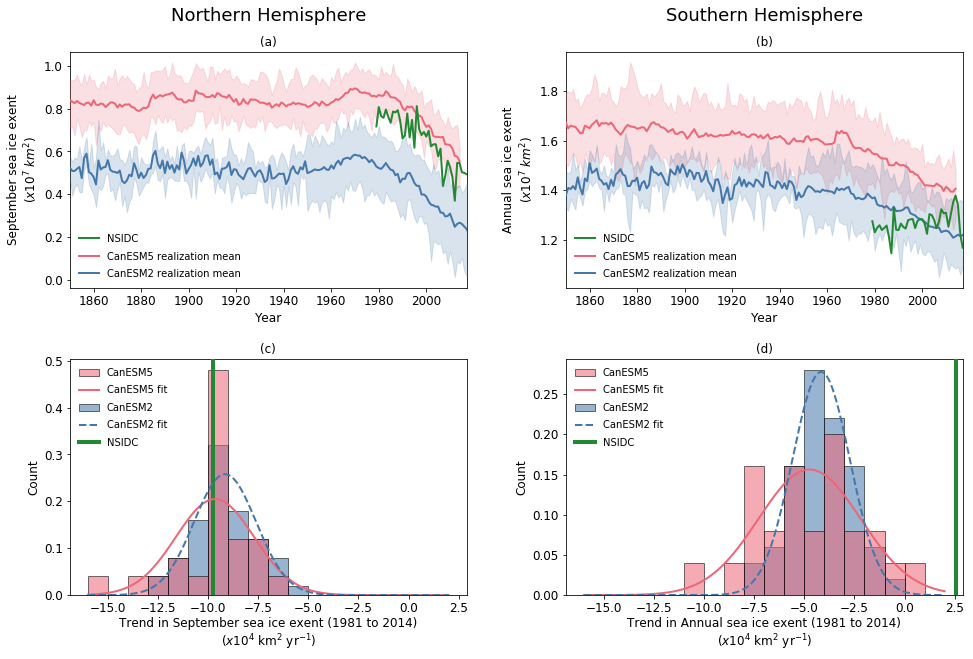

In [15]:
fig = plt.figure(figsize=(16,10))
label_fontsize = 12
title_fontsize = 18
siextent_scale_factor = 1e7
trends_scale_factor = 1e4


ax1 = plt.subplot(2,2,1)
ax1.text(0.5, 1.15, 'Northern Hemisphere', horizontalalignment='center', verticalalignment='center',fontsize=title_fontsize, transform=ax1.transAxes)
ax1.plot(NSIDC_nh_relmean.time, NSIDC_nh_relmean/siextent_scale_factor, label='NSIDC',color=color_dict['NSIDC'],linewidth='2', zorder=20)
ax1.plot(CanESM5_nh_relmean.time, CanESM5_nh_relmean/siextent_scale_factor, label='CanESM5 realization mean',color=color_dict['CanESM5'],linewidth='2', zorder=10)
ax1.plot(CanESM2_nh_relmean.time, CanESM2_nh_relmean/siextent_scale_factor, label='CanESM2 realization mean',color=color_dict['CanESM2'],linewidth='2', zorder=10)
ax1.fill_between(CanESM5_nh_rels.time.values, CanESM5_nh_rels.min(dim='realization')/siextent_scale_factor, CanESM5_nh_rels.max(dim='realization')/siextent_scale_factor, color=color_dict['CanESM5'], alpha=0.2, zorder=10)
ax1.fill_between(CanESM2_nh_rels.time.values, CanESM2_nh_rels.min(dim='realization')/siextent_scale_factor, CanESM2_nh_rels.max(dim='realization')/siextent_scale_factor, color=color_dict['CanESM2'], alpha=0.2, zorder=10)
ax1.set_ylabel(pltm.ylabel_month(nh_month) + ' sea ice exent\n($x10^7$ $km^2$)', fontsize=label_fontsize)   
ax1.set_xlim(1850,2017)
ax1.set_title('(a)')

ax2 = plt.subplot(2,2,2)
ax2.text(0.5, 1.15, 'Southern Hemisphere', horizontalalignment='center', verticalalignment='center',fontsize=title_fontsize, transform=ax2.transAxes)
ax2.plot(NSIDC_sh_relmean.time, NSIDC_sh_relmean/siextent_scale_factor, label='NSIDC',color=color_dict['NSIDC'],linewidth='2', zorder=20)
ax2.plot(CanESM5_sh_relmean.time, CanESM5_sh_relmean/siextent_scale_factor, label='CanESM5 realization mean',color=color_dict['CanESM5'],linewidth='2', zorder=10)
ax2.plot(CanESM2_sh_relmean.time, CanESM2_sh_relmean/siextent_scale_factor, label='CanESM2 realization mean',color=color_dict['CanESM2'],linewidth='2', zorder=10)
ax2.fill_between(CanESM5_sh_rels.time.values, CanESM5_sh_rels.min(dim='realization')/siextent_scale_factor, CanESM5_sh_rels.max(dim='realization')/siextent_scale_factor, color=color_dict['CanESM5'], alpha=0.2, zorder=10)
ax2.fill_between(CanESM2_sh_rels.time.values, CanESM2_sh_rels.min(dim='realization')/siextent_scale_factor, CanESM2_sh_rels.max(dim='realization')/siextent_scale_factor, color=color_dict['CanESM2'], alpha=0.2, zorder=10)
ax2.set_ylabel(pltm.ylabel_month(sh_month) + ' sea ice exent\n($x10^7$ $km^2$)', fontsize=label_fontsize)    
ax2.set_xlim(1850,2017)
ax2.set_title('(b)')

ax3 = plt.subplot(2,2,3)
data_bins=np.arange(-16,2.5,1)
n, bins, patches = ax3.hist(CanESM5_nh_trs/trends_scale_factor, density=True, bins=data_bins, facecolor=color_dict['CanESM5'], edgecolor='k', alpha=0.55, label='CanESM5',zorder=20)
ax3.plot(x_vals/trends_scale_factor, CanESM5_nh_fit_vals*trends_scale_factor, color=color_dict['CanESM5'], linestyle='-', linewidth=2,zorder=30,label='CanESM5 fit')
n, bins, patches = ax3.hist(CanESM2_nh_trs/trends_scale_factor, density=True, bins=data_bins, facecolor=color_dict['CanESM2'], edgecolor='k', alpha=0.55, label='CanESM2',zorder=10)
ax3.plot(x_vals/trends_scale_factor, CanESM2_nh_fit_vals*trends_scale_factor, color=color_dict['CanESM2'], linestyle='--', linewidth=2,zorder=30,label='CanESM2 fit')
ax3.axvline(NSIDC_nh_trends/trends_scale_factor, label='NSIDC', linewidth=4, color=color_dict['NSIDC'],zorder=20)
ax3.set_xlabel('Trend in '+ pltm.ylabel_month(nh_month)+' sea ice exent ('+str(startdate.year)+' to '+str(enddate.year)+')\n($x10^4$ km$^2$ yr$^{-1}$)', fontsize=label_fontsize)    
ax3.set_title('(c)')

ax4 = plt.subplot(2,2,4)
n, bins, patches = ax4.hist(CanESM5_sh_trs/trends_scale_factor, density=True, bins=data_bins, facecolor=color_dict['CanESM5'], edgecolor='k', alpha=0.55, label='CanESM5',zorder=20)
ax4.plot(x_vals/trends_scale_factor, CanESM5_sh_fit_vals*trends_scale_factor, color=color_dict['CanESM5'], linestyle='-', linewidth=2,zorder=30,label='CanESM5 fit')
n, bins, patches = ax4.hist(CanESM2_sh_trs/trends_scale_factor, density=True, bins=data_bins, facecolor=color_dict['CanESM2'], edgecolor='k', alpha=0.55, label='CanESM2',zorder=10)
ax4.plot(x_vals/trends_scale_factor, CanESM2_sh_fit_vals*trends_scale_factor, color=color_dict['CanESM2'], linestyle='--', linewidth=2,zorder=30,label='CanESM2 fit')
ax4.axvline(NSIDC_sh_trends/trends_scale_factor, label='NSIDC', linewidth=4, color=color_dict['NSIDC'],zorder=20)
ax4.set_xlabel('Trend in '+ pltm.ylabel_month(sh_month)+' sea ice exent ('+str(startdate.year)+' to '+str(enddate.year)+')\n($x10^4$ km$^2$ yr$^{-1}$)', fontsize=label_fontsize)    
ax4.set_title('(d)')


for ax in [ax1,ax2]:    
    #ax.grid(True)
    ax.set_xlabel('Year', fontsize=label_fontsize)    
    ax.legend(loc='lower left', ncol=1, labelspacing=0.75,frameon=False )
    
for ax in [ax3,ax4]:  
    ax.set_ylabel('Count', fontsize=label_fontsize)   
    handles, labels = ax.get_legend_handles_labels()
    ax.legend([handles[3],handles[0],handles[4],handles[1],handles[2]], [labels[3],labels[0],labels[4],labels[1],labels[2]],loc='upper left', ncol=1, labelspacing=0.75,frameon=False )
    
plt.subplots_adjust(wspace=0.25, hspace=0.3)     
plt.rcParams['xtick.labelsize']=label_fontsize
plt.rcParams['ytick.labelsize']=label_fontsize


plt.savefig('plots/fig-27_siconc_timeseries_trends.png', bbox_inches='tight')
plt.savefig('plots/fig-27_siconc_timeseries_trends.pdf', bbox_inches='tight')

In [10]:
#monthly trends plot

CanESM5_nh_rels_tr = xr.concat([CanESM5[rel]['monthly_trends_nh'] for rel in CanESM5 if 'monthly_trends_nh' in CanESM5[rel]],dim='realization')
CanESM5_nh_relmean_tr = CanESM5_nh_rels_tr.mean('realization')
CanESM5_sh_rels_tr = xr.concat([CanESM5[rel]['monthly_trends_sh'] for rel in CanESM5 if 'monthly_trends_sh' in CanESM5[rel]],dim='realization')
CanESM5_sh_relmean_tr = CanESM5_sh_rels_tr.mean('realization')

CanESM2_nh_rels_tr = xr.concat([CanESM2[rel]['monthly_trends_nh'] for rel in CanESM2 if 'monthly_trends_nh' in CanESM2[rel]],dim='realization')
CanESM2_nh_relmean_tr = CanESM2_nh_rels_tr.mean('realization')
CanESM2_sh_rels_tr = xr.concat([CanESM2[rel]['monthly_trends_sh'] for rel in CanESM2 if 'monthly_trends_sh' in CanESM2[rel]],dim='realization')
CanESM2_sh_relmean_tr = CanESM2_sh_rels_tr.mean('realization')

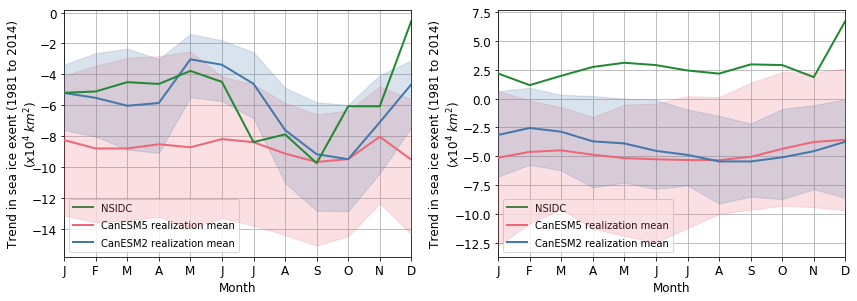

In [11]:
fig = plt.figure(figsize=(14,10))
       
label_fontsize = 12
title_fontsize = 18
trends_scale_factor = 1e4

ax3 = plt.subplot(2,2,1)
ax3.plot(NSIDC_monthly_trends_nh.month, NSIDC_monthly_trends_nh/trends_scale_factor, label='NSIDC',color=color_dict['NSIDC'],linewidth='2', zorder=20)
ax3.plot(CanESM5_nh_relmean_tr.month, CanESM5_nh_relmean_tr/trends_scale_factor, label='CanESM5 realization mean',color=color_dict['CanESM5'],linewidth='2', zorder=10)
ax3.plot(CanESM2_nh_relmean_tr.month, CanESM2_nh_relmean_tr/trends_scale_factor, label='CanESM2 realization mean',color=color_dict['CanESM2'],linewidth='2', zorder=10)
ax3.fill_between(CanESM5_nh_rels_tr.month.values, CanESM5_nh_rels_tr.min(dim='realization')/trends_scale_factor, CanESM5_nh_rels_tr.max(dim='realization')/trends_scale_factor, color=color_dict['CanESM5'], alpha=0.2, zorder=10)
ax3.fill_between(CanESM2_nh_rels_tr.month.values, CanESM2_nh_rels_tr.min(dim='realization')/trends_scale_factor, CanESM2_nh_rels_tr.max(dim='realization')/trends_scale_factor, color=color_dict['CanESM2'], alpha=0.2, zorder=10)


ax4 = plt.subplot(2,2,2)
ax4.plot(NSIDC_monthly_trends_sh.month, NSIDC_monthly_trends_sh/trends_scale_factor, label='NSIDC',color=color_dict['NSIDC'],linewidth='2', zorder=20)
ax4.plot(CanESM5_sh_relmean_tr.month, CanESM5_sh_relmean_tr/trends_scale_factor, label='CanESM5 realization mean',color=color_dict['CanESM5'],linewidth='2', zorder=10)
ax4.plot(CanESM2_sh_relmean_tr.month, CanESM2_sh_relmean_tr/trends_scale_factor, label='CanESM2 realization mean',color=color_dict['CanESM2'],linewidth='2', zorder=10)
ax4.fill_between(CanESM5_sh_rels_tr.month.values, CanESM5_sh_rels_tr.min(dim='realization')/trends_scale_factor, CanESM5_sh_rels_tr.max(dim='realization')/trends_scale_factor, color=color_dict['CanESM5'], alpha=0.2, zorder=10)
ax4.fill_between(CanESM2_sh_rels_tr.month.values, CanESM2_sh_rels_tr.min(dim='realization')/trends_scale_factor, CanESM2_sh_rels_tr.max(dim='realization')/trends_scale_factor, color=color_dict['CanESM2'], alpha=0.2, zorder=10)

for ax in [ax3,ax4]:
    ax.set_xlim(left=1, right=12)
    ax.set_xticks(np.arange(1,13,1))
    ax.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
    ax.set_xlabel('Month', fontsize=label_fontsize)
    #ax.yaxis.set_major_formatter(plticker.FormatStrFormatter('%.1f'))
    ax.grid(True)
    ax.legend(loc='lower left', ncol=1, labelspacing=0.75 )
    ax.set_ylabel('Trend in sea ice exent ('+str(startdate.year)+' to '+str(enddate.year)+')\n($x10^4$ $km^2$)', fontsize=label_fontsize,labelpad=-8)    
    
plt.subplots_adjust(wspace=0.25, hspace=0.2)     
plt.rcParams['xtick.labelsize']=label_fontsize
plt.rcParams['ytick.labelsize']=label_fontsize


plt.savefig('plots/fig-X27_siconc_monthly_trends.png', bbox_inches='tight')

### Stats

In [12]:
##### statistics - for timeseries
xyzt = 'FFFT'
av_dims = ['time','lat','lon'] #dimensions over which to average (time for global time means, time and lon for zonal means and sections,time lat and lon for timeseries)
weight  = None
calc_skill_score = False
start = '1978-12-31'
end = '2014-12-31'

#the following lists will be zipped for the stats calcs, so all info should be entered accordingly
model_names    = ['CanESM5','CanESM5','CanESM2','CanESM2',]
model_datasets    = [CanESM5_nh_relmean.sel(time=(slice(start,end))),CanESM5_sh_relmean.sel(time=(slice(start,end))),
                     CanESM2_nh_relmean.sel(time=(slice(start,end))),CanESM2_sh_relmean.sel(time=(slice(start,end)))]
model_fulldatasets= [None,None,None,None]

obs_names     = ['NSIDC','NSIDC','NSIDC','NSIDC']
obs_datasets     = [NSIDC_nh_relmean.sel(time=(slice(start,end))),NSIDC_sh_relmean.sel(time=(slice(start,end))),
                    NSIDC_nh_relmean.sel(time=(slice(start,end))),NSIDC_sh_relmean.sel(time=(slice(start,end)))]
obs_fulldatasets = [None,None,None,None]

stats_names = ['siextent_sept_nh_timeseries_v_NSIDC','siextent_ann_sh_timeseries_v_NSIDC',
               'siextent_sept_nh_timeseries_v_NSIDC_CanESM2','siextent_ann_sh_timeseries_v_NSIDC_CanESM2',]
varslist = ['siextent_sept_nh','siextent_ann_sh',
            'siextent_sept_nh','siextent_ann_sh']         


bst.calc_stats_and_write(obs_datasets, obs_fulldatasets, obs_names, model_datasets, model_fulldatasets, model_names, stats_names, varslist, weight, xyzt, av_dims, start, end, calc_skill_score=calc_skill_score)

siextent_sept_nh CanESM5 NSIDC
{'bias': 863650.9583333334, 'RMSE': 1019642.3601642316, 'CRMSE': 542012.5135191641, 'corrcoeff': 0.8746591031437858, 'model_std': 973145.9375, 'obs_std': 1118110.3552984719, 'S_bias': None, 'S_rmse': None, 'S_dist': 0.9194853593528763}
siextent_ann_sh CanESM5 NSIDC
{'bias': 1964174.5214994885, 'RMSE': 2122002.398359646, 'CRMSE': 803064.5227728266, 'corrcoeff': -0.5297267515143433, 'model_std': 504561.87740596745, 'obs_std': 412255.5770351447, 'S_bias': None, 'S_rmse': None, 'S_dist': 0.22579296681862454}
siextent_sept_nh CanESM2 NSIDC
{'bias': -2490749.486111111, 'RMSE': 2550106.278502721, 'CRMSE': 547000.0265962112, 'corrcoeff': 0.873009726901304, 'model_std': 933099.375, 'obs_std': 1118110.3552984719, 'S_bias': None, 'S_rmse': None, 'S_dist': 0.9065196436797832}
siextent_ann_sh CanESM2 NSIDC
{'bias': 203308.03479781334, 'RMSE': 790658.2271217008, 'CRMSE': 764072.1661609472, 'corrcoeff': -0.5637682914743004, 'model_std': 451592.95410395827, 'obs_std': 41

In [13]:
#get matching NH and SH 2D fields for stats
start = '1978-12-31'
end = '2014-12-31'
CanESM5_remap = xr.open_dataset('input_data/processed_data/remap-woa09_siconc_SImon_CanESM5_historical_r1i1p1f1_gn_185001-201412.nc')['siconc'].sel(time=(slice(start,end)))
CanESM5_remap_nh = CanESM5_remap.where(CanESM5_remap.lat>0)
CanESM5_remap_sh = CanESM5_remap.where(CanESM5_remap.lat<0)

CanESM2_remap = xr.open_dataset('input_data/processed_data/remap-woa09_sic_OImon_CanESM2_historical_d1r1i1p1_195001-202012.nc')['sic'].sel(time=(slice(start,end)))
CanESM2_remap_nh = CanESM2_remap.where(CanESM2_remap.lat>0)
CanESM2_remap_sh = CanESM2_remap.where(CanESM2_remap.lat<0)

NSIDC_remap_nh = xr.open_dataset('input_data/processed_data/remap-woa09_seaice_conc_monthly_nh_1978-2017_v03r01.nc')['goddard_merged_seaice_conc_monthly'].sel(time=(slice(start,end)))*100
NSIDC_remap_sh = xr.open_dataset('input_data/processed_data/remap-woa09_seaice_conc_monthly_sh_1978-2017_v03r01.nc')['goddard_merged_seaice_conc_monthly'].sel(time=(slice(start,end)))*100


In [14]:
##### statistics - for 2D fields (NH and SH)
xyzt = 'TTFF'
av_dims = ['time'] #dimensions over which to average (time for global time means, time and lon for zonal means and sections,time lat and lon for timeseries)
weight  = xr.open_dataset('input_data/obs/woa/woa09_gridarea.nc')['cell_area']
calc_skill_score = True


#the following lists will be zipped for the stats calcs, so all info should be entered accordingly
model_names    = ['CanESM5','CanESM5','CanESM2','CanESM2',]
model_datasets    = [CanESM5_remap_nh.mean('time'),CanESM5_remap_sh.mean('time'),
                     CanESM2_remap_nh.mean('time'),CanESM2_remap_sh.mean('time')]
model_fulldatasets= [CanESM5_remap_nh,CanESM5_remap_sh,
                     CanESM2_remap_nh,CanESM2_remap_sh]

obs_names     = ['NSIDC','NSIDC','NSIDC','NSIDC']
obs_datasets     = [NSIDC_remap_nh.mean('time'),NSIDC_remap_sh.mean('time'),
                    NSIDC_remap_nh.mean('time'),NSIDC_remap_sh.mean('time')]
obs_fulldatasets = [NSIDC_remap_nh,NSIDC_remap_sh,
                    NSIDC_remap_nh,NSIDC_remap_sh]

stats_names = ['siconc_ann_nh_timemean','siconc_ann_sh_timemean',
               'siconc_ann_nh_timemean_CanESM2','siconc_ann_sh_timemean_CanESM2',]
varslist = ['siconc_ann_nh','siconc_ann_sh',
            'siconc_ann_nh','siconc_ann_sh']         


bst.calc_stats_and_write(obs_datasets, obs_fulldatasets, obs_names, model_datasets, model_fulldatasets, model_names, stats_names, varslist, weight, xyzt, av_dims, start, end, calc_skill_score=calc_skill_score)

/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


siconc_ann_nh CanESM5 NSIDC


/fs/site2/dev/eccc/crd/ccrn/users/scrd104/cmip6_gmd_figures/modules/basic_stats.py:330: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = dataset.indexes['time'].to_datetimeindex() #set all datetime types to datetime64 for S_rmse calc


'DatetimeIndex' object has no attribute 'to_datetimeindex'


/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/fs/site2/dev/eccc/crd/ccrn/users/scrd104/cmip6_gmd_figures/modules/basic_stats.py:269: RuntimeWarning: divide by zero encountered in true_divide
  e_bias = np.abs(bias)/std_flat[combined_indices]
/fs/site2/dev/eccc/crd/ccrn/users/scrd104/cmip6_gmd_figures/modules/basic_stats.py:269: RuntimeWarning: invalid value encountered in true_divide
  e_bias = np.abs(bias)/std_flat[combined_indices]
/fs/site2/dev/eccc/crd/ccrn/users/scrd104/cmip6_gmd_figures/modules/basic_stats.py:299: RuntimeWarning: divide by zero encountered in true_divide
  e_rmse = np.abs(crmse)/std_flat[indices]
/fs/site2/dev/eccc/crd/ccrn/users/scrd104/cmip6_gmd_figures/modules/basic_stats.py:299: RuntimeWarning: invalid value encountered in true_divide
  e_rmse = np.abs(crmse)/std_flat[indices]


{'bias': 0.8767784335055891, 'RMSE': 10.418900075927885, 'CRMSE': 10.381943028386003, 'corrcoeff': 0.9625903948643157, 'model_std': 37.077083266558326, 'obs_std': 38.30803405097191, 'S_bias': 0.4348645508289337, 'S_rmse': 0.1953190267086029, 'S_dist': 0.9802491816146394}
siconc_ann_sh CanESM5 NSIDC
'DatetimeIndex' object has no attribute 'to_datetimeindex'
{'bias': 3.993915376782711, 'RMSE': 9.515110338206998, 'CRMSE': 8.636316633882988, 'corrcoeff': 0.9668736613610515, 'model_std': 32.68630111510871, 'obs_std': 29.373190037987964, 'S_bias': 0.5190426111221313, 'S_rmse': 0.28105711936950684, 'S_dist': 0.9722890089750521}
siconc_ann_nh CanESM2 NSIDC
'DatetimeIndex' object has no attribute 'to_datetimeindex'
{'bias': -6.12203569628151, 'RMSE': 16.421605593209843, 'CRMSE': 15.237775733709462, 'corrcoeff': 0.9245043716786351, 'model_std': 30.970952284988968, 'obs_std': 38.26740845632306, 'S_bias': 0.25811898708343506, 'S_rmse': 0.17057977616786957, 'S_dist': 0.9204415739510591}
siconc_ann_